In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn import preprocessing
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import (LogisticRegression, RidgeClassifier,
                                  SGDClassifier)
from sklearn.metrics import (accuracy_score, fbeta_score, precision_score,
                             recall_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [2]:
data = pd.read_csv(os.path.join(os.getcwd(), 'census.csv'))

In [3]:
data.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [4]:
# From this we can see that no columns have null values from an initial overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [5]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [6]:
# The Profile Report provides a lot of insight into the Feature Data such as:
#      correlation plots between different variables
#      if there is any missing data
#      provides information about each variable (Categorigal vs Quantitative, Bar Charts of each variable)
#      finally, it shows if there are any duplicates in your dataset

profile = ProfileReport(data, title="Data Profile")
profile.to_file("Data_Profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# Based on the Profile, there appears to be a decent bit of duplicates
# We are going to verify that they are truly duplicates and then if so we will remove the duplicate rows of data

data_duplicates = data[data.duplicated(keep=False)]
data_duplicates.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
12,23,Private,Bachelors,13.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
16,32,Private,HS-grad,9.0,Never-married,Machine-op-inspct,Unmarried,White,Male,0.0,0.0,40.0,United-States,<=50K
19,40,Private,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,>50K
25,19,Private,HS-grad,9.0,Never-married,Craft-repair,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K


In [8]:
data_duplicates = data_duplicates.groupby(data_duplicates.columns.tolist(),as_index=False).size().rename(columns={'size': 'duplicate-amount'})
data_duplicates.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,duplicate-amount
0,17,Private,10th,6.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,0.0,15.0,United-States,<=50K,2
1,17,Private,10th,6.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K,3
2,17,Private,10th,6.0,Never-married,Other-service,Other-relative,White,Male,0.0,0.0,15.0,United-States,<=50K,2
3,17,Private,10th,6.0,Never-married,Other-service,Own-child,Black,Male,0.0,0.0,15.0,United-States,<=50K,2
4,17,Private,10th,6.0,Never-married,Other-service,Own-child,White,Female,0.0,0.0,10.0,United-States,<=50K,4


In [9]:
# This proves to us that we actually have duplicates because there is no rows with a duplicate count of only 1
# The reason for removeing duplicates is we want all of the data to be weighted the same, by having duplicates it causes the model to focus more
# on the rows that appear more often than the other rows. There are two ways to solve this, option 1 is to remove duplicates, option 2
# is to change the weighting on each row when training the model. For the sake of simplicity we will do option 1.

data_duplicates['duplicate-amount'].min()

2

In [10]:
no_duplicates_data = data.drop_duplicates()

In [11]:
# Separate Feature Data from it's Label we are trying to predict
y = no_duplicates_data['income']
X = no_duplicates_data.drop(['income'], axis=1)
X = X.rename(columns={'education_level': 'education-level'}) # Just format the unlike coloumn to follow the naming scheme of the other columns

In [12]:
# We use the sklearn LabelEncoder to transform our labels to something more easily processed by our models
# Since it is hard for our models to interpret the strings '<=50k' and '>50k', we can just map these unique strings to an int value
# For example if the label is '<=50k', then we map it to a 0 and '>50k' gets mapped to a 1, this is much easier for the model to underdstand
le = preprocessing.LabelEncoder()
y_encoded = le.fit_transform(y)

In [13]:
X.head()

,age,workclass,education-level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


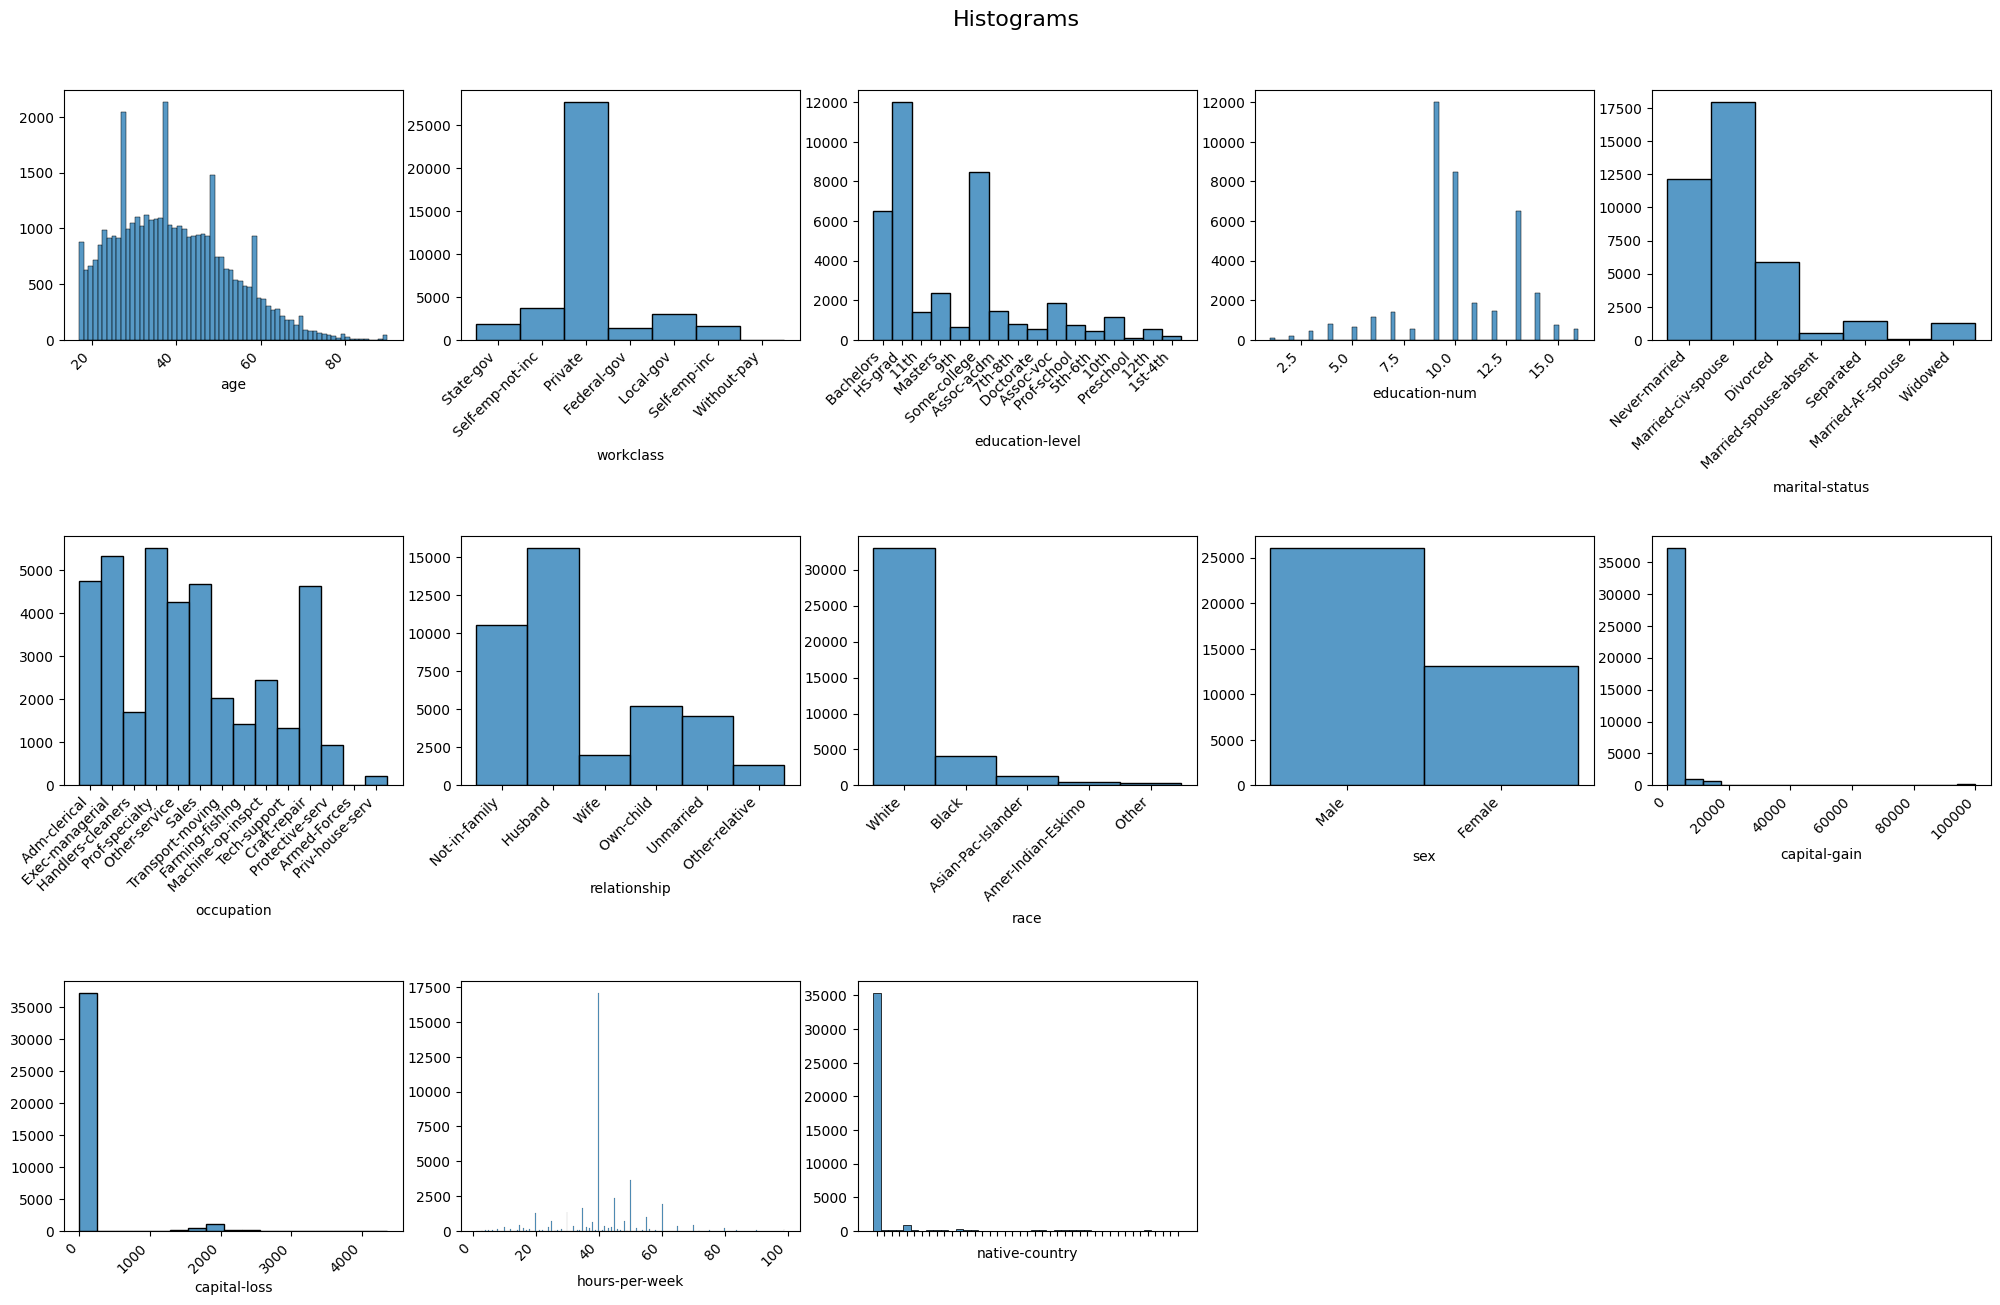

In [14]:
# Based off of these Histograms you get a few insights into each variable
#     For the Quantitative data:
#          - It appears that capital-gain and capital-loss have significant right-skew on the x axis, we should probably do a log scale of the data to get a better look at the distribution of it
#     For the Quantitative data:
#          - Just a note but education-num appears to not be a quantitative variable, but rather some sort of classification

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20,12))
fig.tight_layout(h_pad=12)
counter = 0

for row in range(3):
    for col in range(5):
        if counter < len(X.columns):
            ax = sns.histplot(data=X, x=X.columns[counter], ax=axs[row,col])
            ax.set_ylabel("")
            if X.columns[counter] == 'native-country':
                ax.set_xticklabels("")
            else:
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
            counter+=1
        else:
            axs[row,col].axis('off')

fig.suptitle('Histograms', fontsize=16,y=1.05)
plt.show()

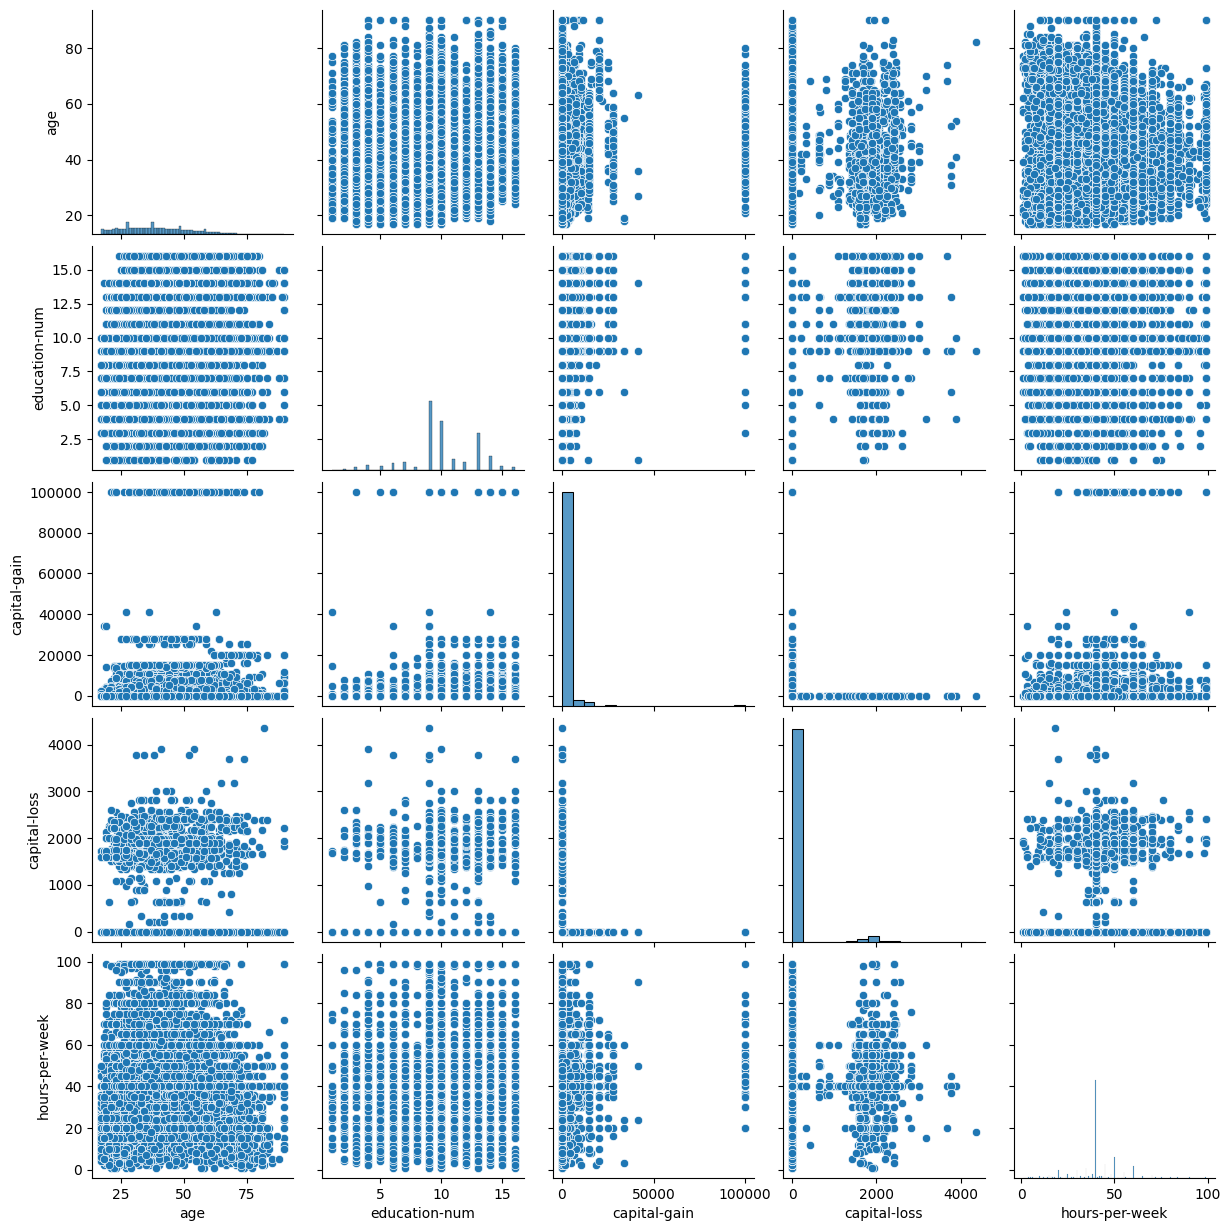

In [15]:
# Look at the correlogram to see if there may be any correlations between each of the different variables.
# The point of looking at this is because we want to try to see if there may be any collinearity with any of our feature variables
# Collinearirity is basically is any of our feature variables are highly correlated with one another. This can end up reducing the performance of our model.
# For more information, please look up and read into collinearity more.
sns.pairplot(X)
plt.show()

In [16]:
# Feature Creation
# - Log Scaling of capital-loss and capital-gain data
# - One Hot Encoding for all qualitative data columns

X = X.merge(X[['capital-gain', 'capital-loss']].apply(lambda x: np.log(1+x)), left_index=True, right_index=True, suffixes=('', '-log'))
X = pd.get_dummies(X, columns=['workclass', 'education-level', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])
X.head()

,age,capital-gain,capital-loss,hours-per-week,capital-gain-log,capital-loss-log,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,2174.0,0.0,40.0,7.684784,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,0.0,0.0,13.0,0.000000,0.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,0.0,0.0,40.0,0.000000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,53,0.0,0.0,40.0,0.000000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,28,0.0,0.0,40.0,0.000000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


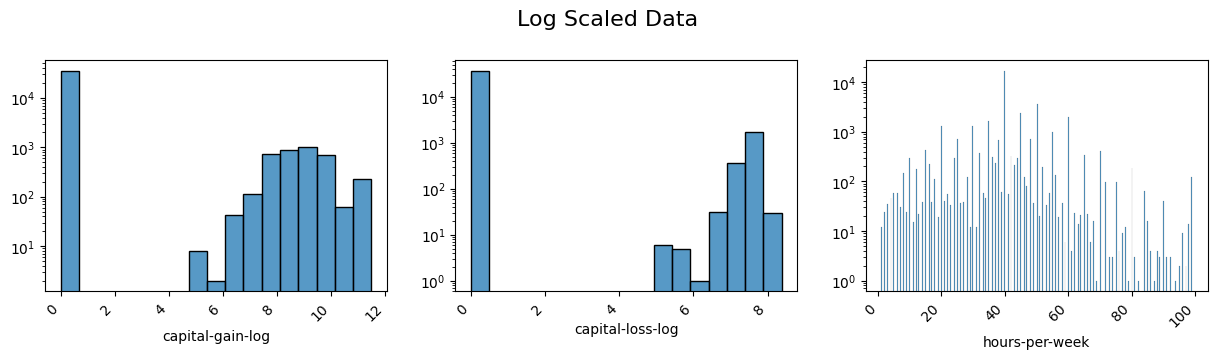

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
log_cols = ['capital-gain-log', 'capital-loss-log', 'hours-per-week']

for col in range(3):
    ax = sns.histplot(data=X, x=log_cols[col], ax=axs[col])
    ax.set_ylabel("")
    ax.set_yscale('log')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
fig.suptitle('Log Scaled Data', fontsize=16,y=1.05)
plt.show()

In [18]:
# Feature Creation
# - Min Max Scaling for age, capital-gain-log, capital-loss-log, 
# - Standard Scaler for hours-per-week
# - The difference between the Min Max Scaler and the Standard Scaler is that the Min Max Scaler strickly looks at the min and max values in the column and
#   scales the data to the unit size. The Standard Sclaer makes the data fit a Guassian Distribution.

min_max_scaler = preprocessing.MinMaxScaler()
X_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(X[['age', 'capital-gain-log', 'capital-loss-log']].values), 
                                columns=['age-min-max-scaled', 'capital-gain-log-min-max-scaled', 'capital-loss-log-min-max-scaled'])

standard_scaler = preprocessing.StandardScaler()
X_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(X[['hours-per-week']].values),
                                 columns=['hours-per-week-standard-scaled'])

In [19]:
X = X.reset_index(drop=True)
X = X.merge(X_min_max_scaled, left_index=True, right_index=True, suffixes=('', ''))
X = X.merge(X_standard_scaled, left_index=True, right_index=True, suffixes=('', ''))

In [20]:
# Now that we have done our feature creation we can now remove the non-scaled columns that we made counterparts for.
# This is because otherwise we would be sending redundant data to the model.

X.drop(['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'capital-gain-log', 'capital-loss-log'], inplace=True, axis=1)
X.head()

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education-level_ 10th,education-level_ 11th,education-level_ 12th,...,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age-min-max-scaled,capital-gain-log-min-max-scaled,capital-loss-log-min-max-scaled,hours-per-week-standard-scaled
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0.301370,0.667492,0.0,-0.096814
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0.452055,0.000000,0.0,-2.264120
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0.287671,0.000000,0.0,-0.096814
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0.493151,0.000000,0.0,-0.096814
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.150685,0.000000,0.0,-0.096814


In [21]:
# Now we split the data into a training and testing split, this allows us to compare performace on in-sample vs out-of-sample data

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=1234)

In [22]:
# Use sklearn classifiers to train and compare models
# Use grid search to optimize each of the hyperparameters for each of the models
# Just a note, the more models and hyperparameters, the longer the training and optimizing will take

models_dict = {'svc': SVC(random_state=1234),
               'ridge': RidgeClassifier(random_state=1234),
               'sgd': SGDClassifier(random_state=1234),
               'log': LogisticRegression(random_state=1234), 
               'rand_forest': RandomForestClassifier(random_state=1234),
               'gb': GradientBoostingClassifier(random_state=1234),
               'ada': AdaBoostClassifier(random_state=1234),
               'd_tree': DecisionTreeClassifier(random_state=1234)}

all_model_parameters = {'svc': {'kernel':('linear','rbf'), 'C':[1,10,100], 'degree':[1,3,5,7]},
                        'ridge': {'alpha':[.5,.75,1.0], 'solver':('auto', 'lsqr', 'sag', 'svd')},
                        'sgd': {'loss':('hinge', 'modified_huber'), 'alpha':[.00005,.0001,.0002]},
                        'log': {'C':[1,10,50,100]}, 
                        'rand_forest': {'n_estimators':[20,50,100,250,500], 'max_depth':[50,100,200,500], 'min_samples_split':[2,4,8,16], 'min_samples_leaf':[1,2,4,8]},
                        'gb': {'loss': ('log_loss', 'exponential'), 'n_estimators':[20,50,100,150,250,500], 'learning_rate':(0.001,0.01,0.1)},
                        'ada': {'n_estimators':[20,50,100,150,250,500], 'learning_rate':(0.001,0.01,0.1)},
                        'd_tree': {'max_depth':[50,100,200,500], 'min_samples_split':[2,4,8,16], 'min_samples_leaf':[1,2,4,8]}}

In [23]:
# Train and optimize all of the models and hyperparameters
# Then we save all of the models to the fit_models dict

fit_models = {}
for algo_name, algo in models_dict.items():
    print(f'Training the {algo_name} model.')
    model = GridSearchCV(algo, all_model_parameters[algo_name], n_jobs=-1, cv=10)
    model.fit(X_train, y_train)
    fit_models[algo_name] = model

Training the svc model.
Training the ridge model.
Training the sgd model.
Training the log model.


C:\Users\Joe\.virtualenvs\Income_Prediction-GM19lNPC\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training the rand_forest model.
Training the gb model.
Training the ada model.
Training the d_tree model.


In [24]:
# Evaluate all of the fit models by comparing metrics
# Also we save every model into it's own pickle incase we want to reload them at a later time

analytics = {'accuracy_training': -1,
             'precision_training': -1,
             'recall_training': -1,
             'f_score_training': -1,
             'accuracy_test': -1,
             'precision_test': -1,
             'recall_test': -1,
             'f_score_test': -1}

results = {'svc': analytics,
           'ridge': analytics,
           'sgd': analytics,
           'log': analytics, 
           'rand_forest': analytics,
           'gb': analytics,
           'ada': analytics,
           'd_tree': analytics}

for algo_name, algo in fit_models.items(): 
    y_training_pred = algo.predict(X_train[:500])
    y_testing_pred = algo.predict(X_test)
    
    results[algo_name]['accuracy_test'] = accuracy_score(y_test, y_testing_pred)
    results[algo_name]['precision_test'] = precision_score(y_test, y_testing_pred)
    results[algo_name]['recall_test'] = recall_score(y_test, y_testing_pred)
    results[algo_name]['f_score_test'] = fbeta_score(y_test, y_testing_pred, beta=0.5)
    
    results[algo_name]['accuracy_training'] = accuracy_score(y_train[:500], y_training_pred)
    results[algo_name]['precision_training'] = precision_score(y_train[:500], y_training_pred)
    results[algo_name]['recall_training'] = recall_score(y_train[:500], y_training_pred)
    results[algo_name]['f_score_training'] = fbeta_score(y_train[:500], y_training_pred, beta=0.5)
    
    with open(f'{algo_name}.pkl', 'wb') as f: 
        pickle.dump(fit_models[algo_name], f)
    
    print('Training Metrics')
    print(f'Metrics for {algo_name}: accuracy- {results[algo_name]["accuracy_training"]}, recall- {results[algo_name]["recall_training"]}, precision- {results[algo_name]["precision_training"]}, f_score- {results[algo_name]["f_score_training"]}')
    print('Testing Metrics')
    print(f'Metrics for {algo_name}: accuracy- {results[algo_name]["accuracy_test"]}, recall- {results[algo_name]["recall_test"]}, precision- {results[algo_name]["precision_test"]}, f_score- {results[algo_name]["f_score_test"]}')

Training Metrics
Metrics for svc: accuracy- 0.826, recall- 0.5671641791044776, precision- 0.7238095238095238, f_score- 0.6859205776173285
Testing Metrics
Metrics for svc: accuracy- 0.838260278627251, recall- 0.5884319625543296, precision- 0.7233867653103164, f_score- 0.6916607718305431
Training Metrics
Metrics for ridge: accuracy- 0.828, recall- 0.5597014925373134, precision- 0.7352941176470589, f_score- 0.6918819188191883
Testing Metrics
Metrics for ridge: accuracy- 0.8367312266394835, recall- 0.5422935473085925, precision- 0.7457471264367816, f_score- 0.6936960054742964
Training Metrics
Metrics for sgd: accuracy- 0.836, recall- 0.5746268656716418, precision- 0.7549019607843137, f_score- 0.7103321033210332
Testing Metrics
Metrics for sgd: accuracy- 0.8383452259599049, recall- 0.5787362086258776, precision- 0.7291491154170177, f_score- 0.6931208456795066
Training Metrics
Metrics for log: accuracy- 0.838, recall- 0.6194029850746269, precision- 0.7345132743362832, f_score- 0.708191126279

In [25]:
# This is how you would go about reloading a pickled model
# Once the this is ran, you can use this reloaded_model object just as you would a normal sklearn model object so you can call predict, etc.

with open(f'd_tree.pkl', 'rb') as f: 
    reloaded_model = pickle.load(f)

In [43]:
# Now we can use the reloaded model (or any of the models stored in the fit_models dict) to make predictions
# We can pass in X values and predict the income of the person
# We also use the LabelEncoder from earlier to transform the encoded labels back to their string values (from a 0 or 1 -> '<=50k' or '>50k' respectively)
# Note: Really we should be passing in x values we used in training or testing because the model has "seen" this data before,
#       the best way to handle this is to test model performance on out of sample data. This is where we should save additional data
#       that the model will never see until the final analysis. Normally what should be done when splitting data is a training, testing, and validation split.
#       Here we only did a training and testing split just for straightforwardness. 

predictions = reloaded_model.predict(X[:10])
le.inverse_transform(predictions)

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '>50K', '<=50K',
       '>50K', '>50K', '>50K'], dtype=object)

In [42]:
# As you can see when comparing the model to the ground truths we only had 1 incorrect classification (position number 6) out of the 10 that we passed to it.
ground_truths = y[:10]
ground_truths

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
5    <=50K
6    <=50K
7     >50K
8     >50K
9     >50K
Name: income, dtype: object